In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import gensim

In [ ]:
import csv
df_fake=pd.read_csv('DataSet_Misinfo_FAKE.csv', error_bad_lines=False, encoding='utf-8')


In [ ]:
df_true=pd.read_csv('DataSet_Misinfo_TRUE.csv',  error_bad_lines=False, encoding='utf-8')

In [ ]:
df_true.head()

,Unnamed: 0,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


In [ ]:
df_true['label']=1
df_fake['label']=0
df_fake=df_fake.drop('Unnamed: 0',axis=1)
df_true=df_true.drop('Unnamed: 0',axis=1)


In [ ]:
df=pd.concat([df_true,df_fake])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78617 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [ ]:
df=df.dropna(how="any")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78588 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [ ]:
y = df["label"].values

X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)


0    43642
1    34946
Name: label, dtype: int64


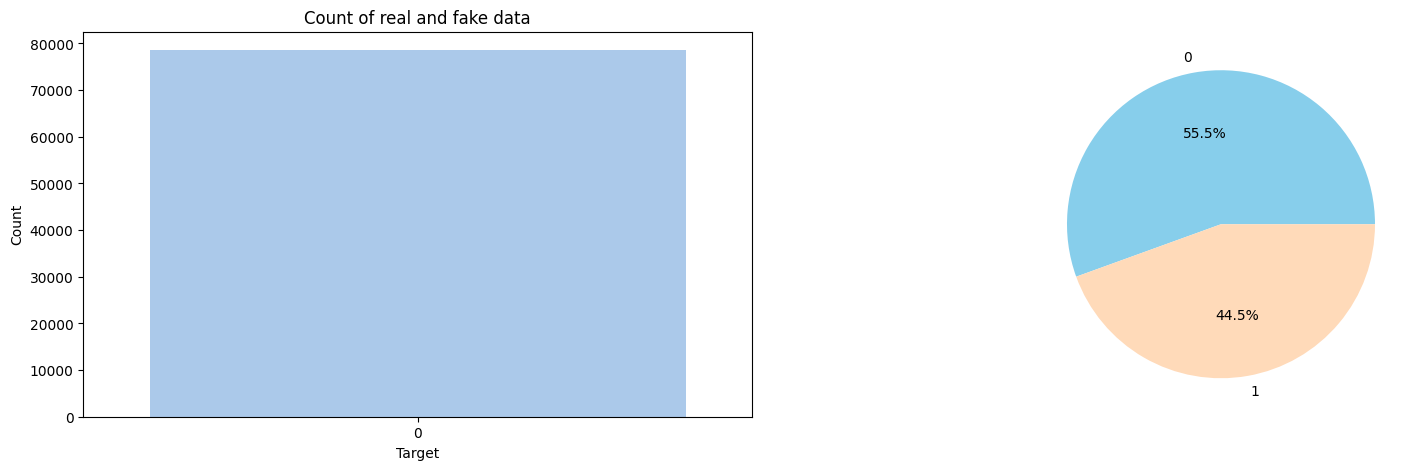

In [ ]:
print(df["label"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot([df['label']],ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Target")
g2 = plt.pie(df["label"].value_counts().values,labels=df.label.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from bs4 import BeautifulSoup
nltk.download('wordnet')
from nltk.corpus import stopwords  


def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters

def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
df['text']=df['text'].apply(cleaning)

[nltk_data] Downloading package wordnet to /root/nltk_data...


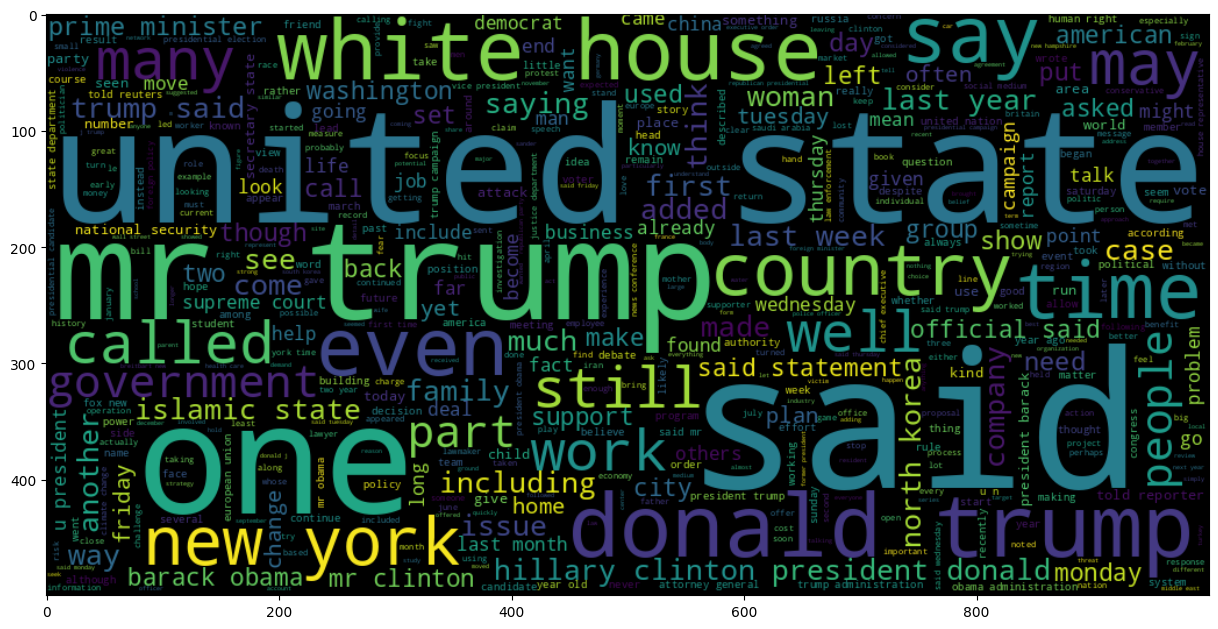

In [12]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

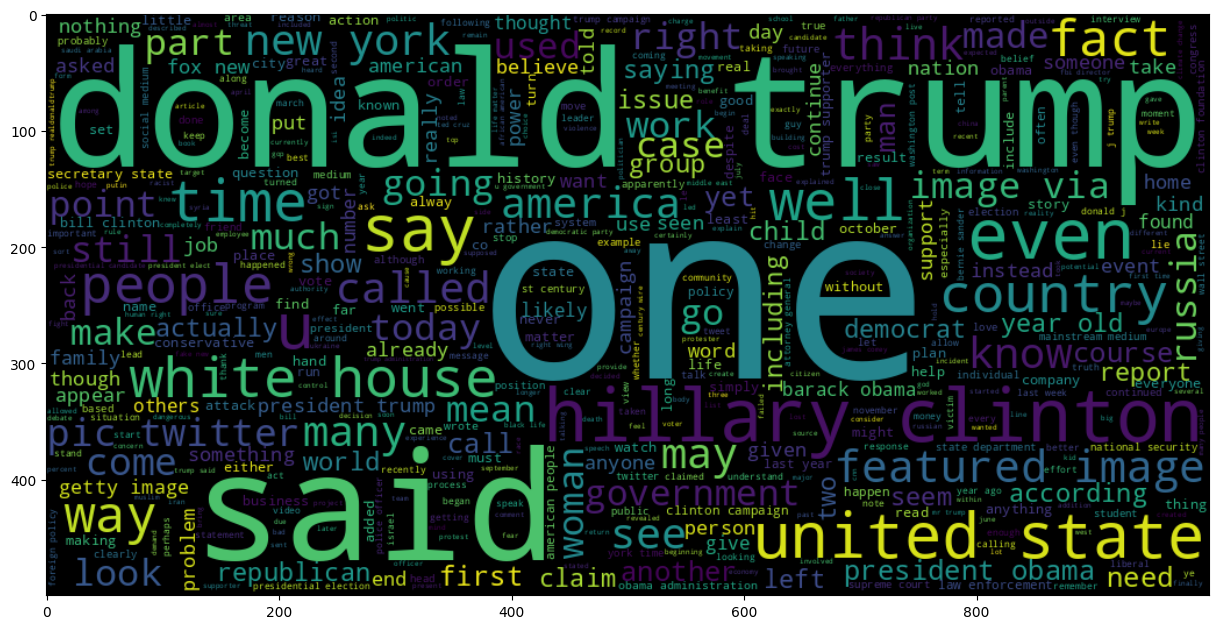

In [13]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(df['text'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum


said 216621
trump 203694
state 109382
would 99719
one 89147
president 89011
people 88195
year 81048
mr 78297
clinton 74010
new 66787
time 66488
also 61944
republican 58316
like 56532
american 55540
government 50596
obama 49884
say 47934
country 47391


<Figure size 2400x800 with 0 Axes>

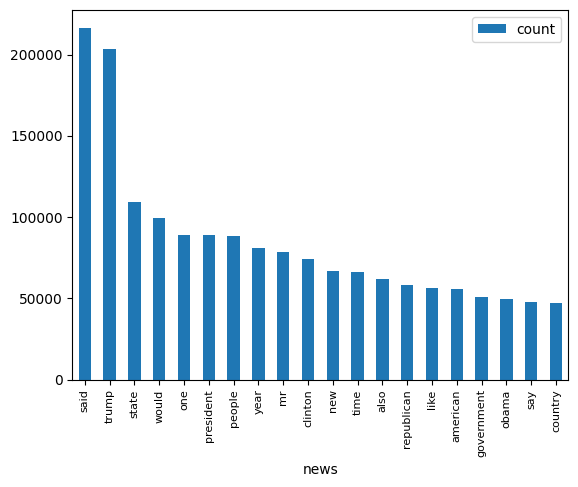

In [25]:
plt.figure(figsize = (24,8))
df1.plot.bar(x='news', y='count', rot=0)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xticks( rotation=90)
plt.show()